## Optimal Taxation Simulation - Constant Elasticity

---

Following BSS's approach

Outline:

* Have individuals optimize （quasi-linear + iso-elastic）
* Numerically integrate FOC 
* Interpolate tax schedule
* Numerically optimize for $z$ and check z(w) is non-decreasing (throw an error otherwise)
* Repeat

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy import integrate
from scipy.interpolate import interp1d

In [2]:
# some global constants
bin_start = 0.01
nbins = 100
bin = 5
top = bin_start + bin * nbins
e = 0.5
gamma = 1
tol = 1e-6 # tolerance for termination

In [3]:
transfer = 0 # initially

### 1. Define the distribution and make a discretized version


We use a log normal distribution with $\mu = 2.757$ and $\sigma = 0.5611$ as MWY though we do not have an atom at $0.01$ for simplicity.

In [4]:
mu = 2.757
sigma = 0.5611

normal = norm(loc = mu, scale = sigma)

# exp^{normal} is log normal with the desired parameters 

wages = [0.01 + bin * i for i in range(0, nbins)] # synnonymous with ability, for now

### 2. Define agents

The utility function we use is:

$$U(c, l) = u(c) + v(l) = c - \frac{n}{1 + 1/e} \cdot \bigg(\frac{z}{n}\bigg)^{1 + 1/e}$$

s.t.

$$ c \leq w \cdot l - T(w \cdot l)$$

Note that $T(0) = -R$ is the transfer.

In [5]:
class Agent:

    def __init__(self, wage):

        # note that this is a separating equilibrium, so higher ability workers always work more 
        # okay to assume the relative ordering stays the same over time

        self.wage = wage
        self.ls = 0.65**e # the guessed labor supply assuming a flat rate of 0.35
        self.util = None
        self.dudc = None # u'(c(theta))
        self.consumption = None
        self.taxpaid = None

    def taxes(self, tax_schedule, earnings):
        '''
        Inputs:
        tax_schedule: (function) that takes in z and returns T(z) - T(0)
        earnings: (float) input z

        Returns:
        (float) tax burden
        '''
        return integrate.quad(tax_schedule, bin_start, earnings, limit=100)[0]
    
    def max_util(self, transfer, tax_schedule):
        '''
        utility maximization assuming Walrus's law holds (no extra budget)
        transfer: from the government.
        tax schedule: see definition aboe
        '''
        
        # negative of the utility function since the routine minimizes instead of optimizes
        
        neg_utility_func = lambda l: -1 * (l * self.wage - self.taxes(tax_schedule, l * self.wage) + transfer - self.wage / (1 + 1/e) * l**(1 + 1/e)) if l >= 0 else 1e9
        result = minimize(neg_utility_func, self.ls)

        self.ls, self.util = result.x[0], result.fun * -1 # new optimal labor supply
        self.taxpaid = self.taxes(tax_schedule, self.wage*self.ls)
        self.consumption = self.wage*self.ls - self.taxpaid + transfer
        self.dudc = 1 # quasi-linear

        return self.ls*self.wage # pre-tax earnings this turn

Intialization for the search is important for the speed of convergence. We use the previous optimal labor supply as an educated guess for the starting point of the search under the new schedule.

### 3. Iterating to find the fixed point

#### 3.1 - Intialize a starting tax schedule $(T'(w) \equiv 0.35)$

In [6]:
# initially - initialize the economy - flat tax schedule
agents = []
tax_schedule = lambda earnings: 0.35 # flat tax; note this specifices T'(z)

for wage in wages:
    agent = Agent(wage)
    optimal_wage = agent.max_util(transfer, tax_schedule)
    agents.append(agent)

#### Update rule:

BSS's update rule, note the difference in SWF compared to MWY

$$\frac{T'(z)}{T'(z)} = \frac{1}{e \cdot w \cdot f(w)} \cdot \int_w^{\infty} \bigg(1 - \frac{u(w)^{-\gamma}}{\lambda}\bigg)f(w)dw$$

$$\lambda = \int_0^{\infty} u(w)^{-\gamma}f(w) dw $$

* Need to interpolate $u(w)^{-\gamma}$

In [8]:
def density_ln(mean, std, x):

    '''
    Helper function that returns the log normal density with the specified parameters at x

    Inputs:
    mean: (float) mean of ln dist
    std: (float) standard deviation of ln dist
    x: (float) evaluation point

    Outputs:
    (float) density
    '''

    return 1/(x * std * np.sqrt(2 * np.pi)) * np.exp(-1 * (np.log(x) - mean)**2 / (2 * std**2))

In [9]:
def interp_util (wages, agents, gamma):

    x = np.array(wages)
    y = np.array([agent.util**(-1 * gamma) for agent in agents])

    # Create an interpolation function
    interp_func = interp1d(x, y, kind='linear', fill_value='extrapolate')

    return interp_func

def interp_revenue (wages, agents):

    x = np.array(wages)
    y = np.array([agent.taxpaid for agent in agents])

    # Create an interpolation function
    interp_func = interp1d(x, y, kind='linear', fill_value='extrapolate')

    return interp_func

In [10]:
interp_gamma_util_func = interp_util(wages, agents, gamma)

In [11]:
iterations = 0

while True:

    print("At iteration: ". iteration)

    revenue_check = True # if the new tansfer is within 1e-6 of the prev
    derivative_check = True # if marginal taxes are not updated by more than 1e-6

    # components of RHS

    interp_gamma_util_func = interp_util(wages, agents, gamma)
    lambda_integrand = lambda w: interp_gamma_util_func(w) * density_ln(mu, sigma, w)
    lambda_mult = integrate.quad(lambda_integrand, bin_start, top, limit=100)[0]
    interp_revenue_func = interp_revenue(wages, agents)

    prev_integral_val = 0
    new_rates = []
    new_zs = []

    rev_integrand = lambda w: interp_revenue_func(w) * density_ln(mu, sigma, w) 
    revenue = integrate.quad(rev_integrand, bin_start, top)[0]

    for (index, agent) in enumerate(reversed(agents)):

        rhs_integrand = lambda w: (1 - interp_gamma_util_func(w) / lambda_mult) * density_ln(mu, sigma, w)
        
        if index == 0:
            rhs_integral_val = integrate.quad(rhs_integrand, agent.wage, top + bin, limit=100)[0]
        else:
            rhs_integral_val = integrate.quad(rhs_integrand, agent.wage, agents[len(agents) - index].wage, limit=100)[0] + prev_integral_val
        
        prev_integral_val = rhs_integral_val
        rhs = 1 / e * 1 / (agent.wage * density_ln(mu, sigma, agent.wage)) * rhs_integral_val
        new_rates.append(rhs/(1 + rhs)) # negative rates never optimal
        new_zs.append(agent.ls * agent.wage)

    if abs(transfer - revenue) > tol:
        revenue_check = False

    transfer = revenue
     
    if revenue_check and derivative_check:
        break

    tax_schedule = interp1d(np.array(new_zs), np.array(new_rates), kind='linear', fill_value='extrapolate')

    for agent in agents:
        optimal_wage = agent.max_util(transfer, tax_schedule)

    iterations += 1

0 

C:\Users\Bryant Xia\AppData\Local\Temp\ipykernel_10332\4071175889.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  lambda_mult = integrate.quad(lambda_integrand, bin_start, top, limit=100)[0]
C:\Users\Bryant Xia\AppData\Local\Temp\ipykernel_10332\3505269339.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(tax_schedule, bin_start, earnings, limit=100)[0]
C:\Users\Bryant Xia\AppData\Local\Temp\ipykernel_10332\3505269339.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(tax_schedule, bin_start, earnings, limit=100)[0]
C:\Users\Bryant Xia\AppData\Local\Temp\ipykernel_10332\350

KeyboardInterrupt: 

### Visuals:

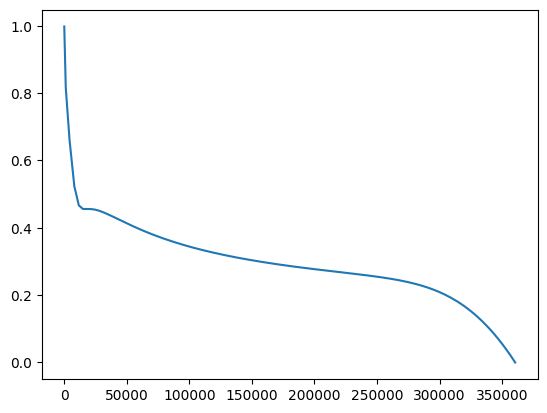

In [ ]:
xs = []
ys = []

for agent in agents:
    xs.append(agent.ls * agent.wage)
    ys.append(tax_schedule(agent.ls * agent.wage))

plt.plot(xs, ys)